# INSTALL RELEVANT PACKAGES

In [ ]:
!pip install fuzzywuzzy python-Levenshtein scikit-learn geonamescache psutil
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
from sklearn.cluster import DBSCAN
import geonamescache
from multiprocessing import Pool, cpu_count
import psutil


In [ ]:
file_path = pd.read_excel('/content/UserData (2).xlsx')

In [ ]:
file_path.head()

,PreferredSponsors,Gender,Country,Degree,Sign Up Date,city,zip,isFromSocialMedia
0,"[""GlobalShala"",""Grant Thornton China"",""Saint L...",Male,Nigeria,Undergraduate Student,2023-07-23T08:05:58.602Z,Owerri,460103,0.0
1,"[""GlobalShala"",""Grant Thornton China"",""Saint L...",Male,India,Undergraduate Student,2023-04-24T09:57:07.405Z,kottayam,686501,0.0
2,"[""GlobalShala"",""Illinois Institute of Technolo...",NaN,India,NaN,2022-10-14T17:13:36.303Z,NaN,NaN,0.0
3,"[""GlobalShala"",""Grant Thornton China"",""Saint L...",NaN,Albania,NaN,2023-06-06T12:29:01.772Z,NaN,NaN,1.0
4,"[""GlobalShala"",""Grant Thornton China"",""Saint L...",Female,Ghana,Not in Education,2023-06-15T16:31:42.719Z,Kumasi,AT-1214-9090,0.0


In [ ]:
file_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27562 entries, 0 to 27561
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PreferredSponsors  27562 non-null  object 
 1   Gender             18027 non-null  object 
 2   Country            27500 non-null  object 
 3   Degree             16750 non-null  object 
 4   Sign Up Date       27562 non-null  object 
 5   city               18028 non-null  object 
 6   zip                18017 non-null  object 
 7   isFromSocialMedia  27553 non-null  float64
dtypes: float64(1), object(7)
memory usage: 1.7+ MB


In [ ]:
file_path.isna().sum()

,0
PreferredSponsors,0
Gender,9535
Country,62
Degree,10812
Sign Up Date,0
city,9534
zip,9545
isFromSocialMedia,9


# DATA CLEANIMG

In [ ]:
df = file_path.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27562 entries, 0 to 27561
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PreferredSponsors  27562 non-null  object 
 1   Gender             18027 non-null  object 
 2   Country            27500 non-null  object 
 3   Degree             16750 non-null  object 
 4   Sign Up Date       27562 non-null  object 
 5   city               18028 non-null  object 
 6   zip                18017 non-null  object 
 7   isFromSocialMedia  27553 non-null  float64
dtypes: float64(1), object(7)
memory usage: 1.7+ MB


In [ ]:
df['Sign Up Date'] = pd.to_datetime(df['Sign Up Date'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f%z')
df['Sign Up Date'] = df['Sign Up Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
df.isna().sum()

,0
PreferredSponsors,0
Gender,9535
Country,62
Degree,10812
Sign Up Date,0
city,9534
zip,9545
isFromSocialMedia,9


In [ ]:
columns = ['Gender', 'Country', 'Degree', 'city', 'zip']
for col in columns:
  df[col] = df[col].fillna('N/A')

In [ ]:
df['isFromSocialMedia'] = df['isFromSocialMedia'].fillna(df['isFromSocialMedia'].mode()[0])

In [ ]:
df.isna().sum()

,0
PreferredSponsors,0
Gender,0
Country,0
Degree,0
Sign Up Date,0
city,0
zip,0
isFromSocialMedia,0


In [ ]:
import ast

# Convert 'PreferredSponsors' from string representation of lists to actual lists
df['PreferredSponsors'] = df['PreferredSponsors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Explode the list of sponsors to have each sponsor in a separate row
df_exploded = df.explode('PreferredSponsors')

# Create a binary table with `Yes` or `No` based on presence of each sponsor
binary_table = pd.crosstab(index=df_exploded.index, columns=df_exploded['PreferredSponsors'])
binary_table = binary_table.map(lambda x: '1' if x > 0 else '0')

# Merge the binary table back with the original DataFrame, dropping the PreferredSponsors column for the final result
user = df.merge(binary_table, left_index=True, right_index=True, how='left')

# Display the first few rows of the transformed DataFrame
user.head()


,PreferredSponsors,Gender,Country,Degree,Sign Up Date,city,zip,isFromSocialMedia,Excelerate,GlobalShala,Grant Thornton China,Illinois Institute of Technology,Saint Louis University
0,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,Nigeria,Undergraduate Student,2023-07-23 08:05:58.602000+00:00,Owerri,460103,0.0,1,1,1,1,1
1,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,India,Undergraduate Student,2023-04-24 09:57:07.405000+00:00,kottayam,686501,0.0,1,1,1,1,1
2,"[GlobalShala, Illinois Institute of Technology...",N/A,India,N/A,2022-10-14 17:13:36.303000+00:00,N/A,N/A,0.0,1,1,1,1,1
3,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,Albania,N/A,2023-06-06 12:29:01.772000+00:00,N/A,N/A,1.0,1,1,1,1,1
4,"[GlobalShala, Grant Thornton China, Saint Loui...",Female,Ghana,Not in Education,2023-06-15 16:31:42.719000+00:00,Kumasi,AT-1214-9090,0.0,1,1,1,1,1


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27562 entries, 0 to 27561
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   PreferredSponsors                 27562 non-null  object             
 1   Gender                            27562 non-null  object             
 2   Country                           27562 non-null  object             
 3   Degree                            27562 non-null  object             
 4   Sign Up Date                      27562 non-null  datetime64[ns, UTC]
 5   city                              27562 non-null  object             
 6   zip                               27562 non-null  object             
 7   isFromSocialMedia                 27562 non-null  float64            
 8   Excelerate                        27562 non-null  object             
 9   GlobalShala                       27562 non-null  object     

In [ ]:
# Remove extra spaces and standardize to title case
for col in ['city', 'Country']:
    user[col] = user[col].astype(str).str.strip().str.title()

# Remove special characters
for col in ['city', 'Country']:
    user[col] = user[col].astype(str).str.replace(r'[^\w\s]', '', regex=True)

In [ ]:
user['Country'].unique().tolist()

['Nigeria',
 'India',
 'Albania',
 'Ghana',
 'United States',
 'Pakistan',
 'Kenya',
 'Bangladesh',
 'Ecuador',
 'Egypt',
 'Mongolia',
 'Vietnam',
 'Mexico',
 'Ethiopia',
 'Australia',
 'Morocco',
 'Philippines',
 'Netherlands',
 'United Arab Emirates',
 'Afghanistan',
 'Norway',
 'Algeria',
 'Peru',
 'Brazil',
 'Cuba',
 'Dominican Republic',
 'Sierra Leone',
 'Nepal',
 'Indonesia',
 'Madagascar',
 'France',
 'Iran Islamic Republic Of Persian Gulf',
 'Cameroon',
 'Zimbabwe',
 'Rwanda',
 'Jamaica',
 'China',
 'Malawi',
 'Zambia',
 'NA',
 'South Africa',
 'American Samoa',
 'Sri Lanka',
 'Libyan Arab Jamahiriya',
 'Falkland Islands Malvinas',
 'Fiji',
 'Saudi Arabia',
 'Tanzania United Republic Of Tanzania',
 'Chile',
 'Somalia',
 'Kazakhstan',
 'Angola',
 'Aland Islands',
 'Aruba',
 'Jordan',
 'Japan',
 'Equatorial Guinea',
 'United Kingdom',
 'Finland',
 'Canada',
 'Liberia',
 'Uganda',
 'Iraq',
 'Mozambique',
 'Romania',
 'Lebanon',
 'Bahrain',
 'Korea Republic Of South Korea',
 'Beni

In [ ]:
user['city'].unique().tolist()

['Owerri',
 'Kottayam',
 'NA',
 'Kumasi',
 'Chennai',
 'Lagos',
 'Ras',
 'Patiala',
 'Sparrows Point',
 'Saint Louis',
 'Accra',
 'Abuja',
 'Peshawar',
 'Vikarabad',
 'Busia',
 'Hyderabad',
 'Naogaon',
 'San Jose',
 'Bhuj',
 'St Loius',
 'Coimbatore',
 'Warangal',
 'Bokaro Steel City',
 'Chicago',
 'Himmatnagar',
 'Vadodara',
 'St Louis',
 'Akure',
 'Ilorin',
 'Howrah',
 'Monmouth Junction',
 'Karachi',
 'Pune',
 'Mumbai',
 'Tirupati',
 'Ajmer',
 'Sukkur',
 'Kolkata',
 'Medchalmalkajgiri',
 'Mclean',
 'Ulaanbaatar',
 'Kandlakoya',
 'Ahmedabad',
 'Qila Saifullah',
 'Bergenfield',
 'Placentia',
 'Ojo',
 'Ghaziabad',
 'Khulna',
 'New Delhi',
 'Visakhapatnam',
 'Saint Louis City',
 'Honolulu',
 'Ado Ekiti',
 'Victoria Island',
 'Gard',
 'Rajahmundry',
 'Aba',
 'Varanasi',
 'Ado',
 'Mexico City',
 'Bangalore',
 'Dhone',
 'Lagos Island',
 'Mayiladuthurai',
 'Midnapore',
 'Qqq',
 'Ho',
 'Medak',
 'Ikotun',
 'Asaba',
 'Krosuru',
 'Gautam Buddha Nagar',
 'Kadiri',
 'Koforidua',
 'Lagos State',


In [ ]:
user['User Index'] = 'USER' + (user.index + 1).astype(str)

In [ ]:
user.head(25)

,PreferredSponsors,Gender,Country,Degree,Sign Up Date,city,zip,isFromSocialMedia,Excelerate,GlobalShala,Grant Thornton China,Illinois Institute of Technology,Saint Louis University,User Index
0,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,Nigeria,Undergraduate Student,2023-07-23 08:05:58.602000+00:00,Owerri,460103,0.0,1,1,1,1,1,USER1
1,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,India,Undergraduate Student,2023-04-24 09:57:07.405000+00:00,Kottayam,686501,0.0,1,1,1,1,1,USER2
2,"[GlobalShala, Illinois Institute of Technology...",N/A,India,N/A,2022-10-14 17:13:36.303000+00:00,NA,N/A,0.0,1,1,1,1,1,USER3
3,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,Albania,N/A,2023-06-06 12:29:01.772000+00:00,NA,N/A,1.0,1,1,1,1,1,USER4
4,"[GlobalShala, Grant Thornton China, Saint Loui...",Female,Ghana,Not in Education,2023-06-15 16:31:42.719000+00:00,Kumasi,AT-1214-9090,0.0,1,1,1,1,1,USER5
5,"[GlobalShala, Grant Thornton China, Saint Loui...",Female,India,N/A,2023-07-06 18:49:16.691000+00:00,Chennai,600033,0.0,1,1,1,1,1,USER6
6,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,Nigeria,N/A,2023-05-15 21:30:04.370000+00:00,NA,N/A,1.0,1,1,1,1,1,USER7
7,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,United States,N/A,2023-07-26 17:01:59.361000+00:00,NA,N/A,1.0,1,1,1,1,1,USER8
8,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,Nigeria,Undergraduate Student,2023-07-27 18:02:17.535000+00:00,Lagos,100278,1.0,1,1,1,1,1,USER9
9,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,India,High School Student,2023-05-05 04:47:25.446000+00:00,Ras,388570,1.0,1,1,1,1,1,USER10


# EXPLORATORY DATA ANALYSIS

In [ ]:
# 1. Perform one-hot encoding
encoded_columns = pd.get_dummies(user[['Gender', 'Degree']], prefix=('Gender', 'Degree'))


# 2. Convert encoded columns to 0 and 1 (if not already)
encoded_columns = encoded_columns.astype(int)

# 3. Concatenate the encoded columns with the original DataFrame
user = pd.concat([user, encoded_columns], axis=1)

# 4. (Optional) Drop the original 'Gender' column if you no longer need it
# user = user.drop('Gender', axis=1)

# Now you have new columns representing each gender category.

In [ ]:
user.columns

Index(['PreferredSponsors', 'Gender', 'Country', 'Degree', 'Sign Up Date',
       'city', 'zip', 'isFromSocialMedia', 'Excelerate', 'GlobalShala',
       'Grant Thornton China', 'Illinois Institute of Technology',
       'Saint Louis University', 'User Index', 'Gender_Don't want to specify',
       'Gender_Female', 'Gender_Male', 'Gender_N/A', 'Gender_Other',
       'Degree_Graduate Program Student', 'Degree_High School Student',
       'Degree_N/A', 'Degree_Not in Education',
       'Degree_Undergraduate Student'],
      dtype='object')

In [ ]:
user.head(10)

,PreferredSponsors,Gender,Country,Degree,Sign Up Date,city,zip,isFromSocialMedia,Excelerate,GlobalShala,...,Gender_Don't want to specify,Gender_Female,Gender_Male,Gender_N/A,Gender_Other,Degree_Graduate Program Student,Degree_High School Student,Degree_N/A,Degree_Not in Education,Degree_Undergraduate Student
0,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,Nigeria,Undergraduate Student,2023-07-23 08:05:58.602000+00:00,Owerri,460103,0.0,1,1,...,0,0,1,0,0,0,0,0,0,1
1,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,India,Undergraduate Student,2023-04-24 09:57:07.405000+00:00,Kottayam,686501,0.0,1,1,...,0,0,1,0,0,0,0,0,0,1
2,"[GlobalShala, Illinois Institute of Technology...",N/A,India,N/A,2022-10-14 17:13:36.303000+00:00,NA,N/A,0.0,1,1,...,0,0,0,1,0,0,0,1,0,0
3,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,Albania,N/A,2023-06-06 12:29:01.772000+00:00,NA,N/A,1.0,1,1,...,0,0,0,1,0,0,0,1,0,0
4,"[GlobalShala, Grant Thornton China, Saint Loui...",Female,Ghana,Not in Education,2023-06-15 16:31:42.719000+00:00,Kumasi,AT-1214-9090,0.0,1,1,...,0,1,0,0,0,0,0,0,1,0
5,"[GlobalShala, Grant Thornton China, Saint Loui...",Female,India,N/A,2023-07-06 18:49:16.691000+00:00,Chennai,600033,0.0,1,1,...,0,1,0,0,0,0,0,1,0,0
6,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,Nigeria,N/A,2023-05-15 21:30:04.370000+00:00,NA,N/A,1.0,1,1,...,0,0,0,1,0,0,0,1,0,0
7,"[GlobalShala, Grant Thornton China, Saint Loui...",N/A,United States,N/A,2023-07-26 17:01:59.361000+00:00,NA,N/A,1.0,1,1,...,0,0,0,1,0,0,0,1,0,0
8,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,Nigeria,Undergraduate Student,2023-07-27 18:02:17.535000+00:00,Lagos,100278,1.0,1,1,...,0,0,1,0,0,0,0,0,0,1
9,"[GlobalShala, Grant Thornton China, Saint Loui...",Male,India,High School Student,2023-05-05 04:47:25.446000+00:00,Ras,388570,1.0,1,1,...,0,0,1,0,0,0,1,0,0,0


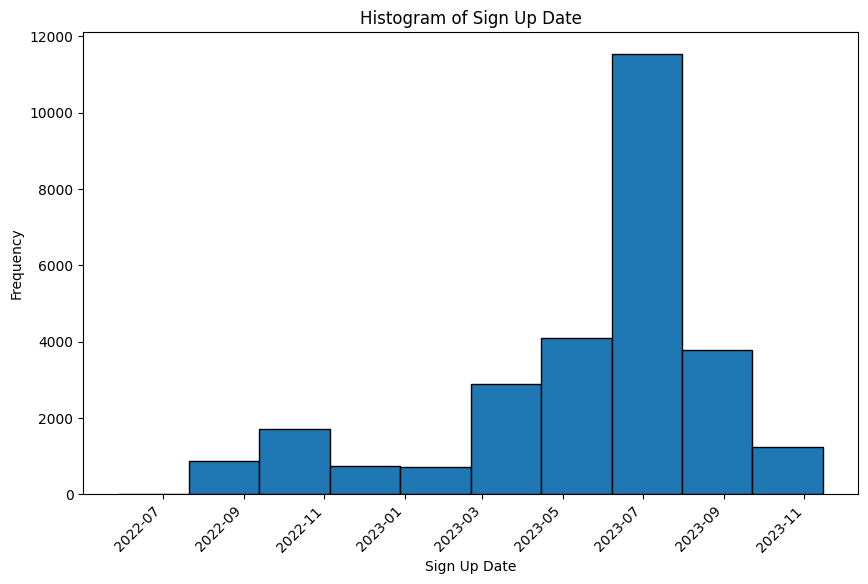

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.hist(user['Sign Up Date'], bins=10, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Sign Up Date')
plt.ylabel('Frequency')
plt.title('Histogram of Sign Up Date')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# To know if there were any inconsistent Date and potential outliers
print('Maximum date:', user['Sign Up Date'].max())
print('Minimum date:', user['Sign Up Date'].min())

Maximum date: 2023-11-15 00:18:57.358000+00:00
Minimum date: 2022-05-28 07:11:37.690000+00:00


In [ ]:
user['city'].nunique()

4015

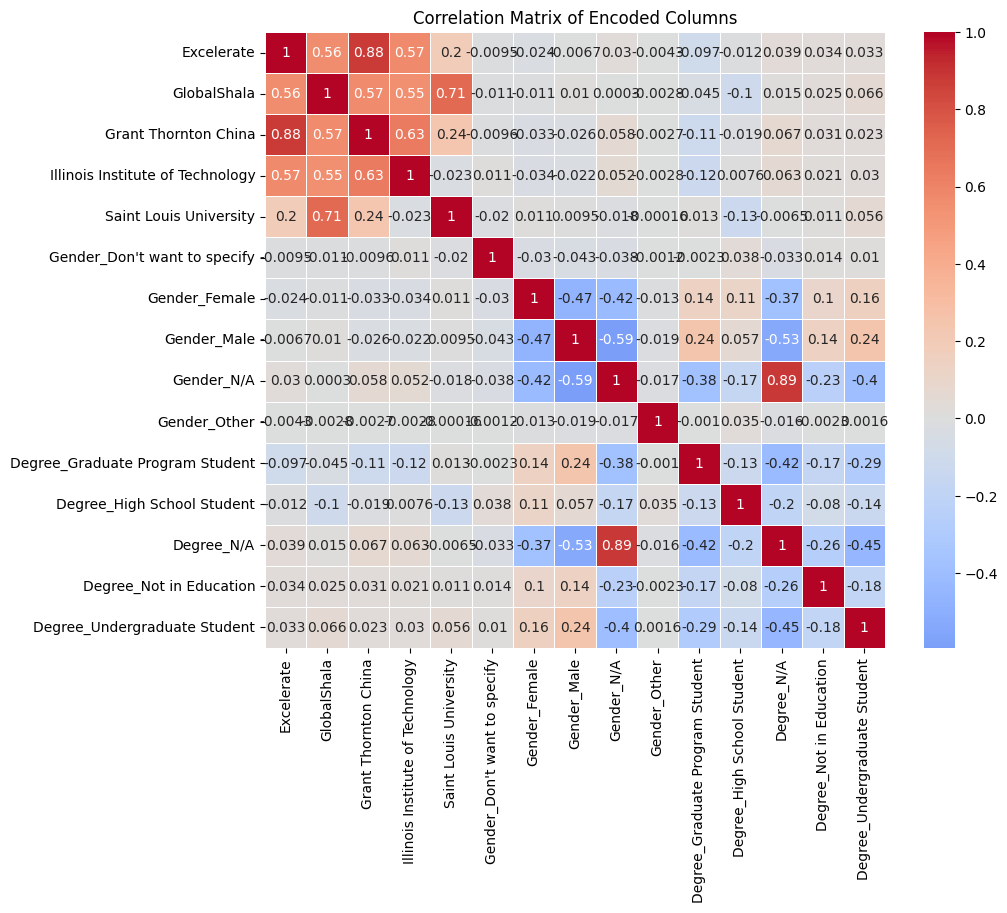

Strong correlations (>|0.7|):
Excelerate              Grant Thornton China      0.877143
GlobalShala             Saint Louis University    0.710901
Grant Thornton China    Excelerate                0.877143
Saint Louis University  GlobalShala               0.710901
Gender_N/A              Degree_N/A                0.886784
Degree_N/A              Gender_N/A                0.886784
dtype: float64


In [ ]:
# To check for correlation between all encoded columns
encoded_columns = ['Excelerate', 'GlobalShala','Grant Thornton China', 'Illinois Institute of Technology',
                    'Saint Louis University', "Gender_Don't want to specify",'Gender_Female', 'Gender_Male',
                    'Gender_N/A', 'Gender_Other', 'Degree_Graduate Program Student', 'Degree_High School Student',
                    'Degree_N/A', 'Degree_Not in Education', 'Degree_Undergraduate Student']   # Replace with your actual column names

# Step 1: Calculate the correlation matrix using Spearman's method (good for ordinal or encoded columns)
correlation_matrix = user[encoded_columns].corr(method='spearman')

# Step 2: Visualize the Correlation Matrix with a Heatmap
plt.figure(figsize=(10, 8))  # Adjust size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Encoded Columns')
plt.show()

# Step 3: Identify Strong Correlations (>|0.7| or <|-0.7|) excluding self-correlations
threshold = 0.7
strong_correlations = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)].stack()

# Drop self-correlations (correlation of a column with itself)
strong_correlations = strong_correlations[strong_correlations.index.get_level_values(0) != strong_correlations.index.get_level_values(1)]

print("Strong correlations (>|0.7|):")
print(strong_correlations)


In [ ]:
# To clean City column and remove naming inconsistencies using Fuzzy Matching and Clustering Technique
# --- 1. Enhanced Standardization ---
def standardize_city_name(city):
    city = city.strip().title()
    city = city.replace('St.', 'Saint').replace('L.A.', 'Los Angeles')  # Example abbreviation mapping
    return city

def parallel_apply(series, func):
    with Pool(cpu_count()) as p:
        result = p.map(func, series)
    return pd.Series(result, index=series.index)

user['city'] = parallel_apply(user['city'], standardize_city_name)

# --- 2. Fuzzy Matching ---
unique_cities = user['city'].unique().tolist()
matched_cities = {}

for city in unique_cities:
    match, score = process.extractOne(city, unique_cities, scorer=fuzz.token_set_ratio)
    if score >= 85 and match != city:
        matched_cities[city] = match

user['city'] = user['city'].replace(matched_cities)

# --- 3. DBSCAN Clustering ---
batch_size = 3000
clustered_cities = []

for i in range(0, len(unique_cities), batch_size):
    batch = unique_cities[i:i + batch_size]
    similarity_matrix = np.zeros((len(batch), len(batch)))

    for i in range(len(batch)):
        for j in range(i + 1, len(batch)):
            similarity_matrix[i, j] = fuzz.token_set_ratio(batch[i], batch[j]) / 100
            similarity_matrix[j, i] = similarity_matrix[i, j]

    distance_matrix = 1 - similarity_matrix
    dbscan = DBSCAN(eps=0.2, min_samples=2, metric='precomputed')
    clusters = dbscan.fit_predict(distance_matrix)

    clustered_cities.extend(zip(batch, clusters))

# Convert clustered data to a DataFrame
clustered_df = pd.DataFrame(clustered_cities, columns=['city', 'cluster'])

# Replace cities with a consistent name within each cluster
for cluster_id in clustered_df['cluster'].unique():
    if cluster_id != -1:
        cluster_cities = clustered_df[clustered_df['cluster'] == cluster_id]['city'].tolist()
        preferred_name = cluster_cities[0]
        user['city'] = user['city'].replace(cluster_cities, preferred_name, inplace=True)

# --- 4. Validation with Geonamescache ---
gc = geonamescache.GeonamesCache()
cities = gc.get_cities()

def validate_city_name(city):
    for city_data in cities.values():
        if fuzz.token_set_ratio(city, city_data.get('name', '')) >= 85:
            return city_data.get('name')
    return city

user['validated_city'] = parallel_apply(user['city'], validate_city_name)

print("City cleaning and validation complete")

<ipython-input-232-290ee5f74a84>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user['city'].replace(cluster_cities, preferred_name, inplace=True)


City cleaning and validation complete


In [233]:
user['validated_city'].unique().tolist()

['Owerri',
 'Kottayam',
 'Néa Smýrni',
 'Kumasi',
 'Chennai',
 'San Juan de los Lagos',
 'Ras Al Khaimah City',
 'Patiāla',
 'Sparrows Point',
 'Peshawar',
 'Vikarabad',
 'Busia',
 'Pār Naogaon',
 'San José',
 'Bhuj',
 'Coimbatore',
 'Chicago',
 'Himatnagar',
 'Vadodara',
 'Howrah',
 'Monmouth Junction',
 'Karachi',
 'Tirupati',
 'Ajmer',
 'Sukkur',
 'Kolkata',
 'Medchalmalkajgiri',
 'McLean',
 'Ulaanbaatar',
 'Kandlakoya',
 'Ahmedabad',
 'Qila Saifullah',
 'Bergenfield',
 'Placentia',
 'Mojo',
 'Ghaziabad',
 'Khulna',
 'Visakhapatnam',
 'Honolulu',
 'Gard',
 'Rājahmundry',
 'Maba',
 'Varanasi',
 'Dhone',
 'Mayiladuthurai',
 'Qqq',
 'Medak',
 'Ikotun',
 'Asaba',
 'Krosuru',
 'Nagar',
 'Kadiri',
 'Koforidua',
 'Wilmette',
 'Gangtou',
 'Cherpulassery',
 'Ooty',
 'Gajwel',
 'Buffalo Grove',
 'Naugachhia',
 'Ogidi',
 'Addis Ababa',
 'Guntur',
 'Narsampet',
 'Rajarhat',
 'Junagadh',
 'Dubai',
 'Meerut',
 'Morganville',
 'Nagpur',
 'Maidan Wardak',
 'Osogbo',
 'Palwal',
 'Molde',
 'Sale',
 '

In [234]:
user['validated_city'].nunique()

2959

In [235]:
user['city'] = user['validated_city']

In [236]:
# To confirm that the code worked
user[['city', 'validated_city']].head(15)

,city,validated_city
0,Owerri,Owerri
1,Kottayam,Kottayam
2,Néa Smýrni,Néa Smýrni
3,Néa Smýrni,Néa Smýrni
4,Kumasi,Kumasi
5,Chennai,Chennai
6,Néa Smýrni,Néa Smýrni
7,Néa Smýrni,Néa Smýrni
8,San Juan de los Lagos,San Juan de los Lagos
9,Ras Al Khaimah City,Ras Al Khaimah City


In [238]:
# Drop validated_city column
user.drop('validated_city', axis = 1, inplace = True)

In [248]:
user.columns

Index(['PreferredSponsors', 'Gender', 'Country', 'Degree', 'Sign Up Date',
       'city', 'zip', 'isFromSocialMedia', 'Excelerate', 'GlobalShala',
       'Grant Thornton China', 'Illinois Institute of Technology',
       'Saint Louis University', 'User Index', 'Gender_Don't want to specify',
       'Gender_Female', 'Gender_Male', 'Gender_N/A', 'Gender_Other',
       'Degree_Graduate Program Student', 'Degree_High School Student',
       'Degree_N/A', 'Degree_Not in Education',
       'Degree_Undergraduate Student'],
      dtype='object')

In [249]:
# Define the desired order of columns
new_column_order = ['User Index', 'PreferredSponsors', 'Gender', 'Degree', 'city', 'zip', 'Country', 'Sign Up Date',
                    'isFromSocialMedia', 'Excelerate', 'GlobalShala','Grant Thornton China', 'Illinois Institute of Technology',
                     'Saint Louis University', "Gender_Don't want to specify", 'Gender_Female', 'Gender_Male', 'Gender_N/A',
                    'Gender_Other', 'Degree_Graduate Program Student', 'Degree_High School Student', 'Degree_N/A', 'Degree_Not in Education',
                     'Degree_Undergraduate Student']

# Reorder the columns
user = user[new_column_order]

In [252]:
cleaned_data = user.to_csv('cleaned_userdata.csv', index=False)